In [234]:
#from ipywidgets import interactive, IntSlider,FloatSlider

#from lcapy import Circuit, j, omega, s

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lti
import control as ct
#from scipy.stats import expon
#import scipy.fftpack as fourier
#from scipy.fftpack import fft, fftfreq, fftshift

#import seaborn as sns
#import sympy as syn
#import sklearn as skn
#from scipy.stats import norm
#from sklearn.neighbors import KernelDensity
from scipy import signal
import math

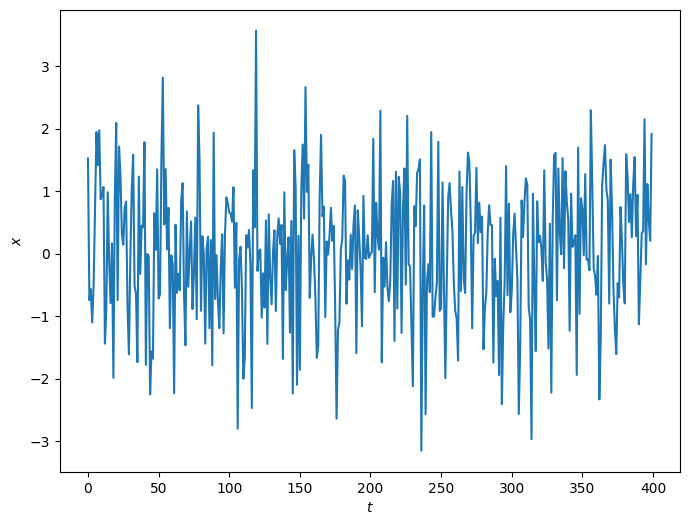

In [235]:
###  señales de entrada


dt = 0.01 # base de tiempo
t=np.arange(0,4,dt)

N =  len(t)# // numero de muestras 
μ  = 0
V2 = 1.21 
#Ruido Gaussiano
real_G = np.random.normal(μ, np.sqrt(V2), N) ## FDP GAUSSIANA REAL 

#grafica del ruido
plt.figure(figsize=(8,6))
plt.plot(np.arange(N), real_G)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

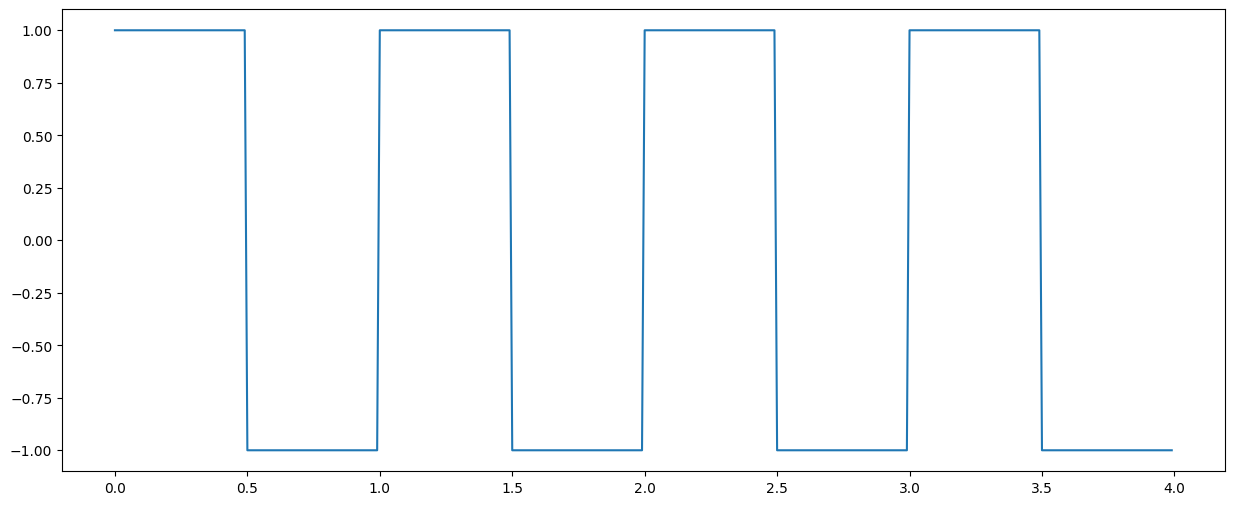

In [236]:
# señal cuadrada
square = signal.square(2 * np.pi * t)
plt.figure(figsize=(15,6))
plt.plot(t, square)
plt.show()


In [237]:
### señal

senal = real_G

In [238]:
# asignacion de valores y grafica de la funcion de transferencia

C1 = 2.7e-6
C2 = 1e-6
R1 = 3300
R2 = 6200

s = ct.tf('s')
H = 1/(C1*C2*R1*R2*s**2+(C1*R1+C2*R2+C2*R2)*s+1)

ct.tf(H)




TransferFunction(array([1]), array([5.5242e-05, 2.1310e-02, 1.0000e+00]))

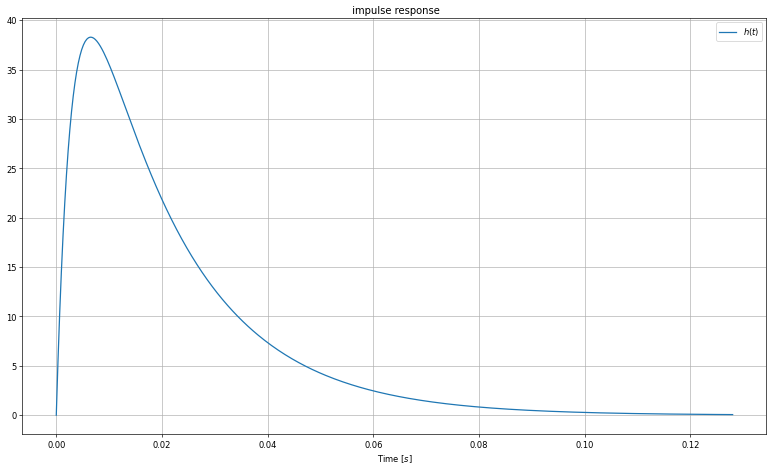

In [239]:
## Definicion del sistema lineal 
coef_num =[1]
coef_den=[C1*C2*R1*R2, C1*R1+C2*R2+C2*R2, 1]

lti_system=lti(coef_num,coef_den)
Nsample = len(t)
t,h= lti_system.impulse(N = Nsample)

# grafica respuesta impulso del sistema
plt.figure(figsize=(16,9), dpi=60)
plt.plot(t,h, label = '$h(t)$')
plt.grid()
plt.legend()
plt.title(' impulse response')
plt.xlabel('Time [$s$]')
plt.show()

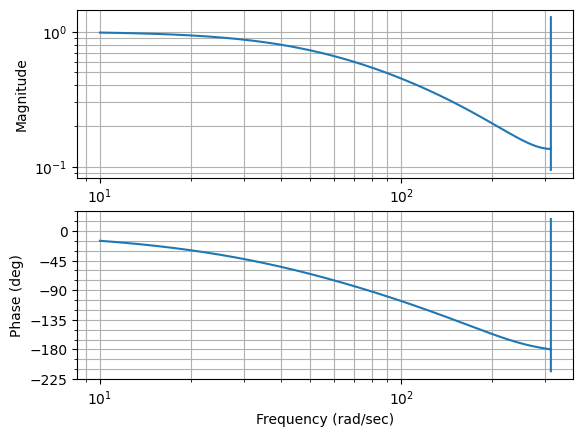

In [240]:
# diagrama de Bode del sistema

sys = ct.TransferFunction(coef_num,coef_den)
sys_d = ct.c2d(sys, dt)

ct.bode_plot(sys_d)
plt.show()

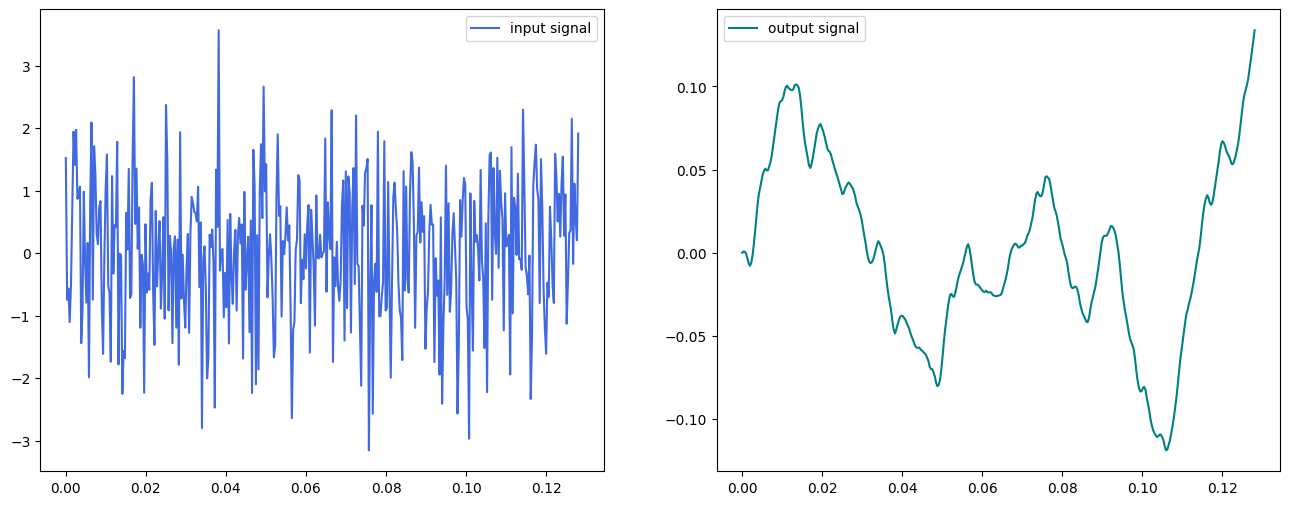

In [241]:
# grafica de la señal de entrada y salida del circuito


Nsample = len(t)

expt = senal

_,Output_circuit,_ = lti_system.output(expt,t) 

fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(t, expt,color='royalblue',label='input signal')
ax[0].legend()
ax[1].plot(t, Output_circuit,color = 'teal',label='output signal')
ax[1].legend()
plt.show()

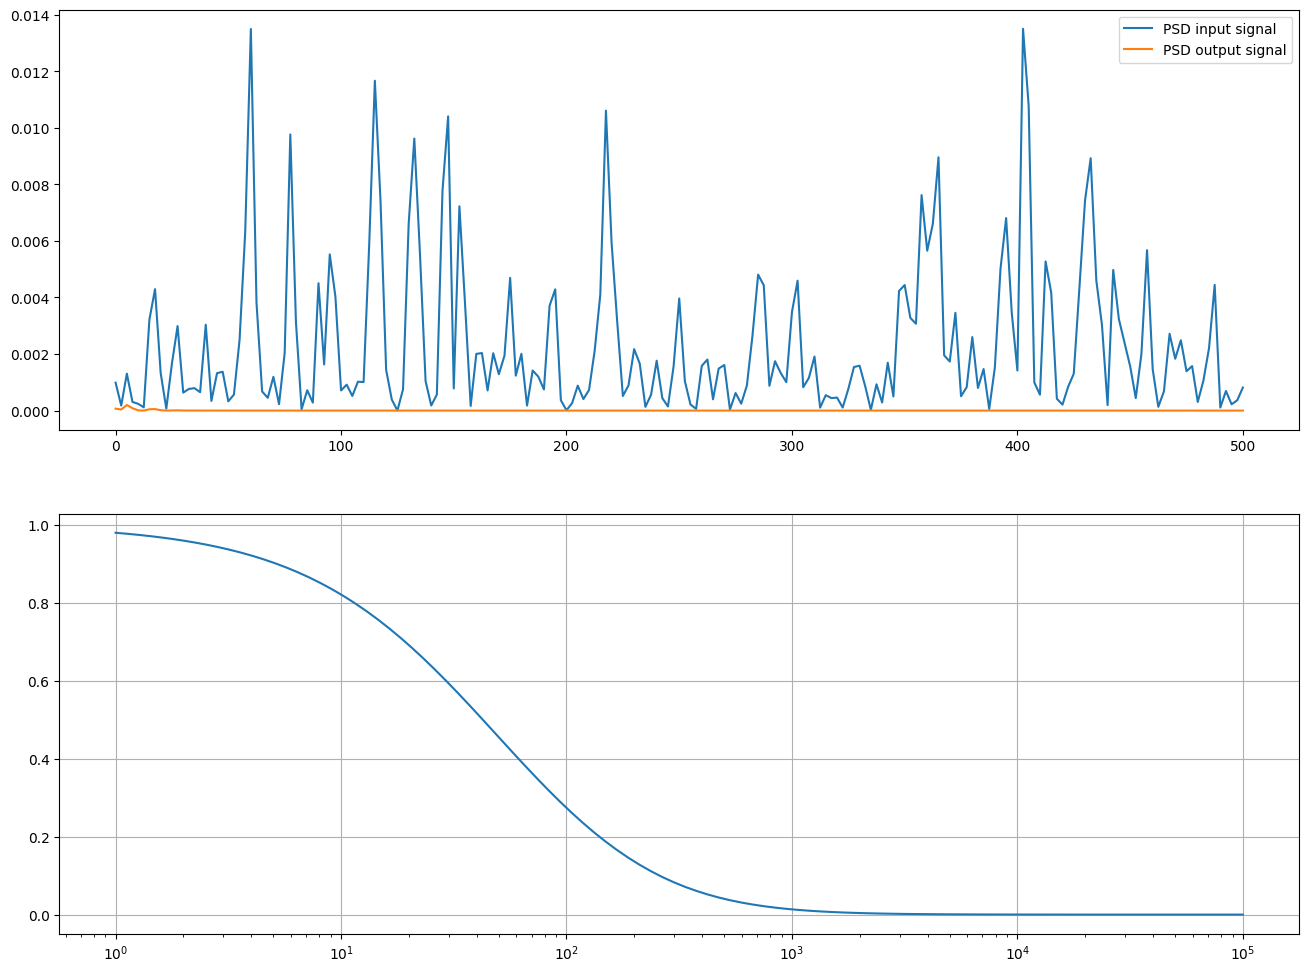

In [242]:
fs = 1000  # Frecuencia de muestreo (Hz)
# Calcular la PSD
f, Pxx = signal.welch(senal, fs, nperseg=len(t))
f2, Pxx2 = signal.welch(Output_circuit, fs, nperseg=len(t))
freq = np.logspace(0,5,100)
tf = 1/(5.24*10**(-5)*freq**2 +0.02131*freq+1)
# Graficar la PSD
fig, ax=plt.subplots(2,1,figsize=(16,12))
#plt.ylabel('Densidad espectral de potencia')
ax[0].plot(f, Pxx,label='PSD input signal')
ax[0].plot(f2, Pxx2,label='PSD output signal')
ax[0].legend()
#plt.title('PSD')

ax[1].semilogx(freq,tf)
#plt.xlabel('Frecuencia (Hz)')


plt.grid(True)
plt.show()

# correlacion, PSD
## Autocorrelacion
$$R_x = \int{\xi(t)\xi*(t-\tau)dt}$$

en correlacion se hace una comparacion de formas,

para la autocorrelacion, s ehace una correlacion entre puntos, es decir, se compara el punto $t_i$ con cualquiera de los otros puntos $t_{i+\delta}$
en cierta medida, con estos dos operadores se obtiene informacion

auto correlacion se relaciona con informacion e incertidumbre, se asume que en $t=0$ estamos en el momento actual, en este momento se conoce toda la informacion, en ese momento se conoce el maximo, que mide la informacion y la energia de la señal, la funcion de autocorrelacion con mayor pendiente (derivada) indica que la señal tiene mucha incertidumbre, por esa razon la autocorrelacion de un ruido gaussiano da un delta porque ningun punto esta relacionado con el otro. 


si la funcion es periodica, la autocorrelacion tambien sera periodica, debido a que la derivada de una funcion periodica es tambien una funcion periodica.


## PSD

$$ PSD = ft(R_x)$$
Se trata de un analisis inverso a la autocorrelacion, en este caso, para el ruido gaussiano todas las frecuencias aportan y la informacion es menor, por eso al pasar el ruido por el filtro, se eliminan frecuencias, por tanto la informacion es mayor, y la grafica de la densidad espectral de potencia debe atenuarse

### Entrada
real_G

### salida
Output_circuit


$\tau =0$ correponde a la correlacion de la variable aleatoria consigo misma

In [243]:
# encontramos la media, como se trata de un ruido gaussiano, esta sera = N_0
Pxx.mean()

0.0023756469375157702

In [244]:
# funcion que calcula la autocorrelacion 
def correlacion(data, tau):
    N= len(data)
    dx=0.001
    suma = 0
    for x in data:
        suma = suma + x*dx*(x+tau)

    return 1/N *suma 


def densidad_espectral(R):
    return 2*R
           
    
R_x1 = correlacion(senal,0)
densidad_espectral(R_x1)

R2 = correlacion(Output_circuit,0)
print(R_x1, ' \\\\\\\\\ ',R2)


0.0012121444145179387  \\\\\  2.9137263761686143e-06


In [245]:
## se muestra el espectro de potencia  que corresponde a N_0 /2 * delta
import scipy.fftpack as fourier
import sympy as sym


tau = sym.symbols('t',real=True)
N02= R_x1*sym.DiracDelta(tau)
N02


0.00121214441451794*DiracDelta(t)

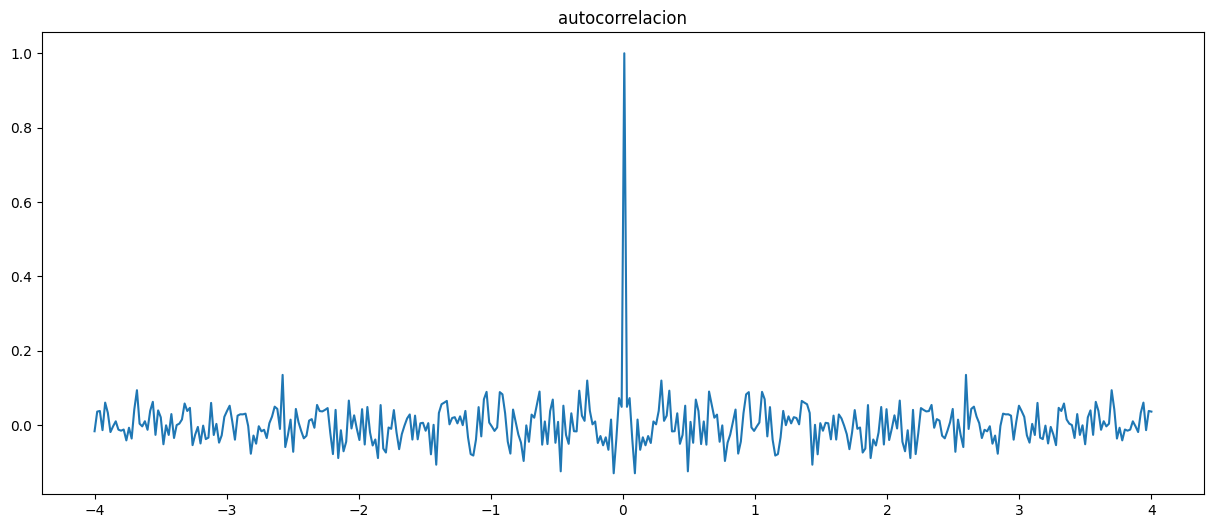

In [246]:
## graficar la autucorrelacion de la señal de entrada


cor = np.correlate(senal,senal,mode='same')
max = np.max(cor)
normalice=[]
for x in cor:
    normalice.append(x/max)

time = np.linspace(-4,4,len(normalice))
plt.figure(figsize=(15,6))
plt.plot(time, normalice)
plt.title('autocorrelacion')
plt.show()


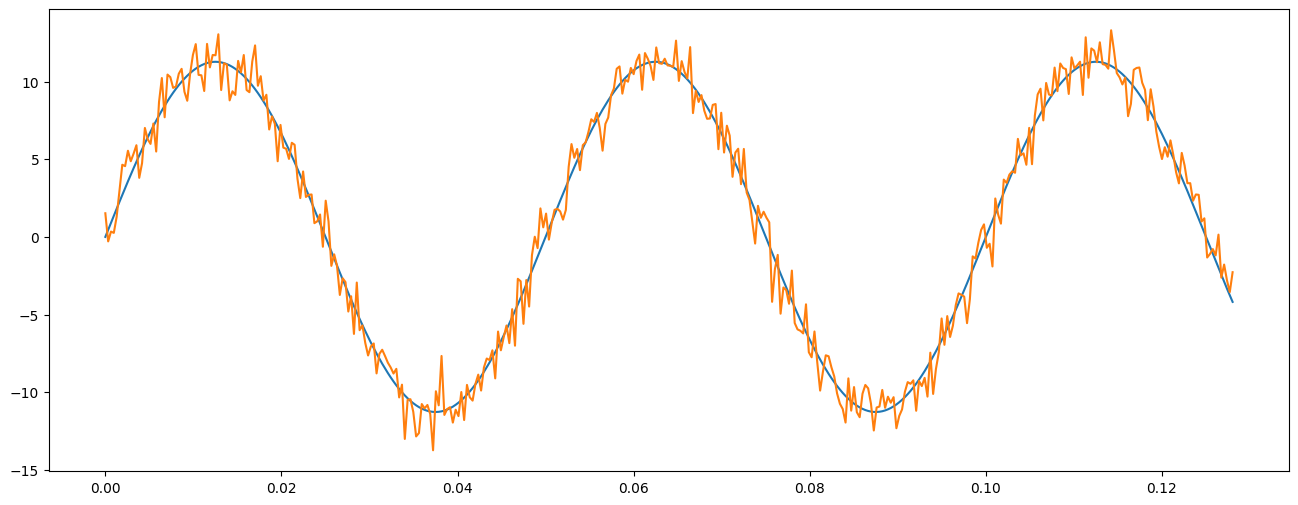

In [247]:
#dt = 0.01 # base de tiempo
#t=np.arange(0,4,dt)

## pruebas con señales senoidales, se les añadio el ruido gaussiano  definido como Real_G
pico = np.max(senal)
db = 10
amplitud = pico*10**(db/20)
signal2 = amplitud*np.sin(2*np.pi*20*t)

suma = signal2+senal

plt.figure(figsize=(16,6))
plt.plot(t,signal2)
plt.plot(t,suma)
plt.show()

In [249]:
## Funcion para normalizar los datos
def normalizar2(x):
    max = np.max(x)
    normal =np.zeros(len(x))
    for i in range(len(x)):
        normal[i]=x[i]/max
        
    return normal

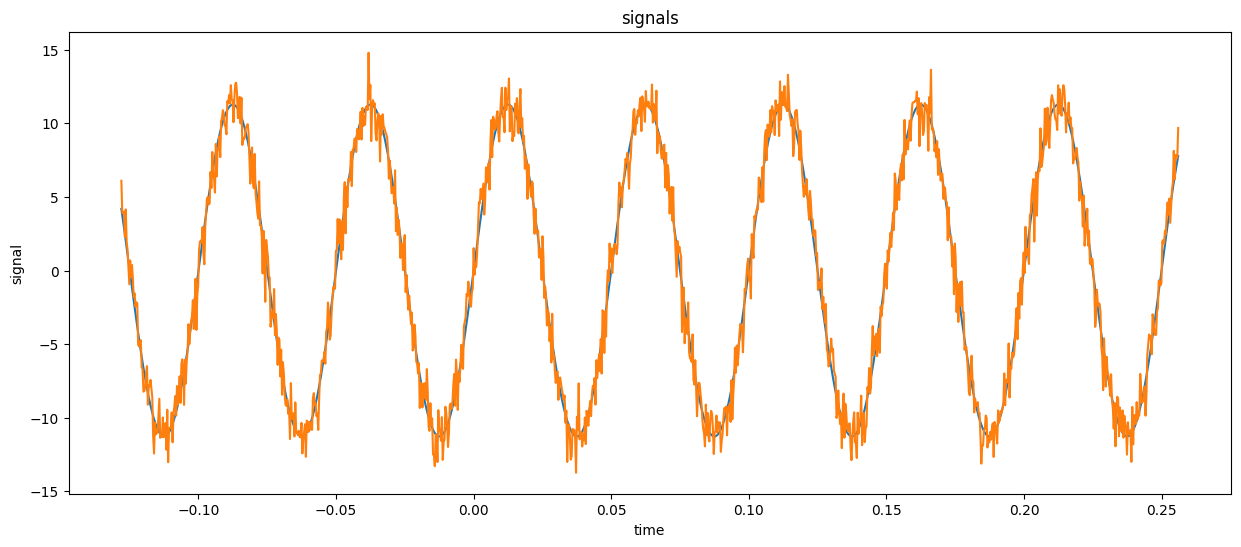

In [250]:
## Grafica de las señales con ruido y sin ruido



#timetry2 = np.linspace(-4,8,3*len(t))
#signaltry2 = amplitud*np.sin(2*np.pi*20*timetry2)
timetry2 = np.concatenate((np.flip(-t),t,t+t[-1]))
signaltry2 = np.concatenate((np.flip(amplitud*np.sin(2*np.pi*20*(-t))),signal2,amplitud*np.sin(2*np.pi*20*(t+t[-1]))))

sumatry2 = np.concatenate((np.flip(amplitud*np.sin(2*np.pi*20*(-t)))+np.flip(senal),signal2+senal,amplitud*np.sin(2*np.pi*20*(t+t[-1]))+senal))

plt.figure(figsize=(15,6))
plt.plot(timetry2,signaltry2)
plt.plot(timetry2,sumatry2)
plt.title('signals')
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

In [251]:
signaltry2.shape

(1200,)

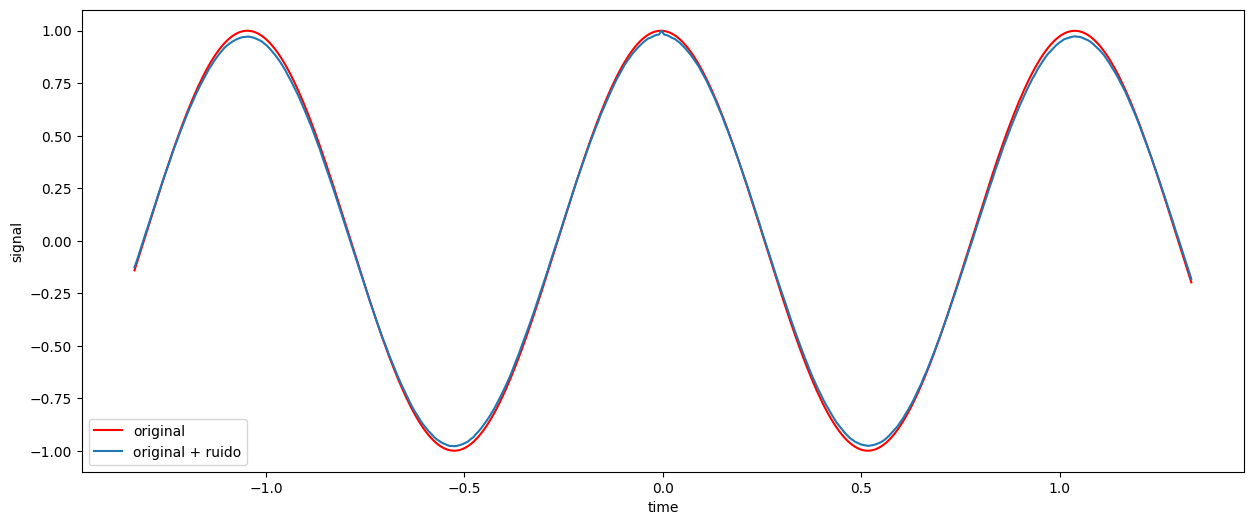

In [252]:
## Correlacion de señales original y señal con ruido



cor1 = np.correlate(signal2,signaltry2,mode='same')
cor2 = np.correlate(suma,sumatry2,mode='same')
normalice1 = normalizar2(cor1)
normalice2 = normalizar2(cor2)

time = np.linspace(-4,4,len(normalice1))
plt.figure(figsize=(15,6))
plt.plot(time[400:800], normalice1[400:800], label='original',color='red')
plt.plot(time[400:800], normalice2[400:800],label='original + ruido')
plt.xlabel('time')
plt.ylabel('signal')
#plt.plot(range(len(normalice1)), normalice1,label='suma sinusoide + ruido')
plt.legend()
plt.show()

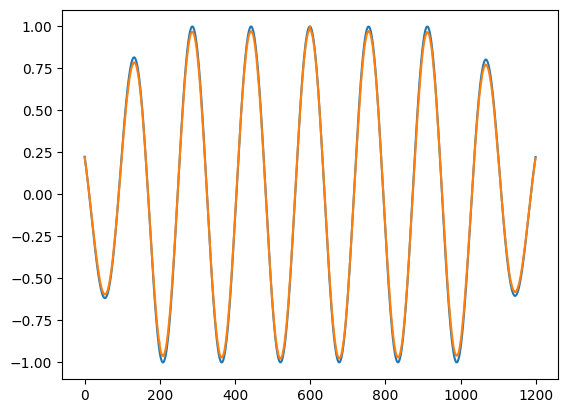

In [253]:
plt.plot(normalice1)
plt.plot(normalice2)
plt.show()